In [13]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import utils
import skutils
import copy
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

seed = 47

# Use ggplot style
plt.style.use('ggplot')

%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
big = train

big.species = big.species.astype('category')
big.species = big.species.cat.codes

# big = pd.get_dummies(big, sparse=True)

big.species

0       3
1      49
2      65
3      94
4      84
5      40
6      54
7      78
8      53
9      89
10     98
11     16
12     74
13     50
14     58
15     31
16     43
17      4
18     75
19     44
20     83
21     84
22     13
23     66
24     15
25      6
26     73
27     22
28     73
29     31
       ..
960    85
961    89
962    94
963    45
964    48
965    86
966    81
967    14
968     4
969    77
970    56
971    82
972     2
973    85
974    70
975    88
976     0
977    75
978    14
979    86
980    81
981    97
982    70
983    72
984    34
985    40
986     5
987    11
988    78
989    50
Name: species, dtype: int8

In [4]:
def transform(data):
    ID = data.id
    X = data.drop(['species', 'id'], axis=1)
    y = data['species']
    return ID, X, y

ID, X, y = transform(big)

In [5]:
def addZeroColumn(df, colName):
    df.loc[df[colName] < 0.01, colName + '_is_small'] = 1
    df[colName + '_is_small'].fillna(0, inplace=True)

def addZeroColumns(df, colBaseName):
    for n in range(1,65):
        addZeroColumn(df, colBaseName + str(n))
        
addZeroColumns(X, 'margin')
addZeroColumns(X, 'texture')

In [37]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, recall_score, cohen_kappa_score, auc, make_scorer, average_precision_score, f1_score, brier_score_loss, log_loss
from sklearn.pipeline import Pipeline

classifiers = {
    "LR_std": { "f": Pipeline([
                ('scaling', StandardScaler()),
                ('estimator', LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1))
            ]) },
    "RF": { "f": RandomForestClassifier(n_estimators=100, n_jobs=-1) },
    
    "LR_std": { "f": Pipeline([
                ('scaling', StandardScaler()),
                ('estimator', LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1))
            ]) },
    "LR_mm": { "f": Pipeline([
                ('scaling', MinMaxScaler()),
                ('estimator', LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1))
            ]) },
    "LR_rob": { "f": Pipeline([
                ('scaling', RobustScaler()),
                ('estimator', LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1))
            ]) },
    "RF_std": { "f": Pipeline([
                ('scaling', StandardScaler()),
                ('estimator', RandomForestClassifier(n_estimators=100, n_jobs=-1))
            ]) },
    "RF_mm": { "f": Pipeline([
                ('scaling', MinMaxScaler()),
                ('estimator', RandomForestClassifier(n_estimators=100, n_jobs=-1))
            ]) },
    "RF_rob": { "f": Pipeline([
                ('scaling', RobustScaler()),
                ('estimator', RandomForestClassifier(n_estimators=100, n_jobs=-1))
            ]) },
}   

classifiers = {
        "LR_1": { "f": LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1, C=1, penalty='l2') },
        "LR_2": { "f": LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1, C=0.8, penalty='l2') },
        "LR_3": { "f": LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1, C=1.2, penalty='l2') },
        "LR_4": { "f": LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1, C=10, penalty='l2') },
        "LR_5": { "f": LogisticRegression(solver='newton-cg', multi_class='multinomial', n_jobs=-1, C=1, penalty='l2') },
        "LR_6": { "f": LogisticRegression(solver='newton-cg', multi_class='multinomial', n_jobs=-1, C=0.8, penalty='l2') },
        "LR_7": { "f": LogisticRegression(solver='newton-cg', multi_class='multinomial', n_jobs=-1, C=1.2, penalty='l2') },
        "LR_8": { "f": LogisticRegression(solver='newton-cg', multi_class='multinomial', n_jobs=-1, C=10, penalty='l2') },
        "RF_1": { "f": RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='gini', min_samples_leaf=1) },
        "RF_2": { "f": RandomForestClassifier(n_estimators=10, n_jobs=-1, criterion='gini', min_samples_leaf=1) },
        "RF_3": { "f": RandomForestClassifier(n_estimators=20, n_jobs=-1, criterion='gini', min_samples_leaf=1) },
        "RF_4": { "f": RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='gini', min_samples_leaf=1) },
        "RF_5": { "f": RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='gini', min_samples_leaf=3) },
        "RF_6": { "f": RandomForestClassifier(n_estimators=10, n_jobs=-1, criterion='gini', min_samples_leaf=3) },
        "RF_7": { "f": RandomForestClassifier(n_estimators=20, n_jobs=-1, criterion='gini', min_samples_leaf=3) },
        "RF_8": { "f": RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='gini', min_samples_leaf=3) },
        "RF_9": { "f": RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='entropy', min_samples_leaf=1) },
        "RF_A": { "f": RandomForestClassifier(n_estimators=10, n_jobs=-1, criterion='entropy', min_samples_leaf=1) },
        "RF_B": { "f": RandomForestClassifier(n_estimators=20, n_jobs=-1, criterion='entropy', min_samples_leaf=1) },
        "RF_C": { "f": RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='entropy', min_samples_leaf=1) },
}  

measures = {
    'pre': precision_score,
    'rec': recall_score,
    'acc': accuracy_score,
    'ck': cohen_kappa_score,
    'f1': f1_score,
}

sizes = []
for i in range(1,9):
    sizes.append(0.1 + 0.1 * i)

In [38]:
def test_split(size):
    sss = StratifiedShuffleSplit(10, test_size=size, random_state=seed)
    clfs = copy.deepcopy(classifiers)
    
    for clf in clfs.keys(): 
        c = clfs[clf]   
        for meas in measures.keys():
            c[meas] = []

    for train_index, test_index in sss.split(X, y):

        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        for clf in clfs.keys():                    
            c = clfs[clf]    
            c["f"].fit(X_train, y_train)
            y_pred = np.asarray(c["f"].predict(X_test))

            for meas in measures.keys():
                m = measures[meas]

                if (meas != 'ck' and meas != 'acc' and meas != 'br'):
                    c[meas].append(m(y_test, y_pred, average='macro'))
                elif (meas == 'll'):
                    c[meas].append(m(y_test, y_pred, labels=y_test))
                else:
                    c[meas].append(m(y_test, y_pred))
    
    return clfs
               
cl = []
    
for s in sizes:
    cl.append(test_split(s))

/home/stevie/Develop/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stevie/Develop/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stevie/Develop/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stevie/Develop/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

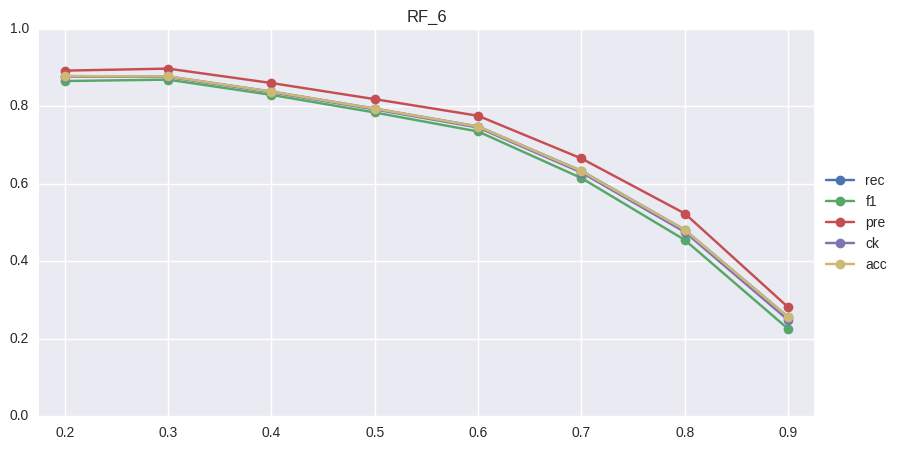

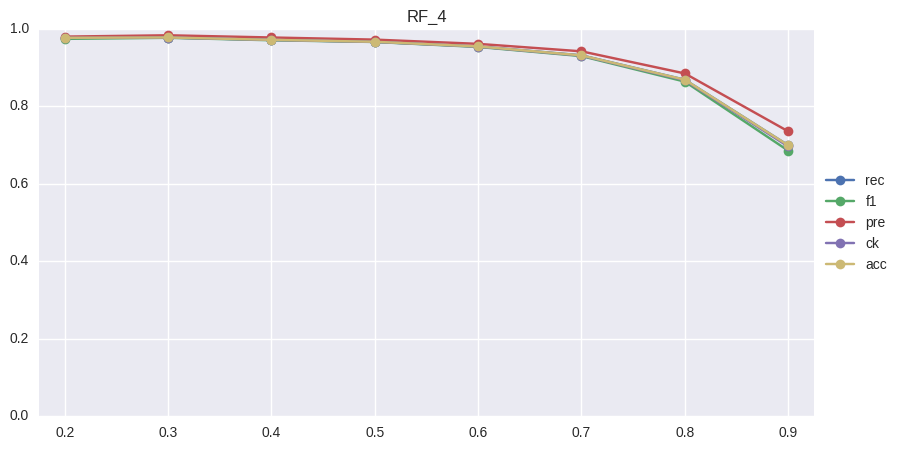

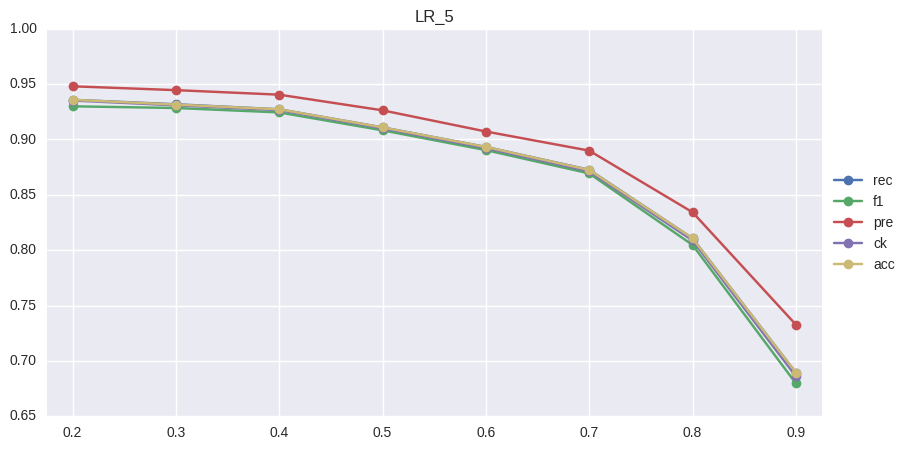

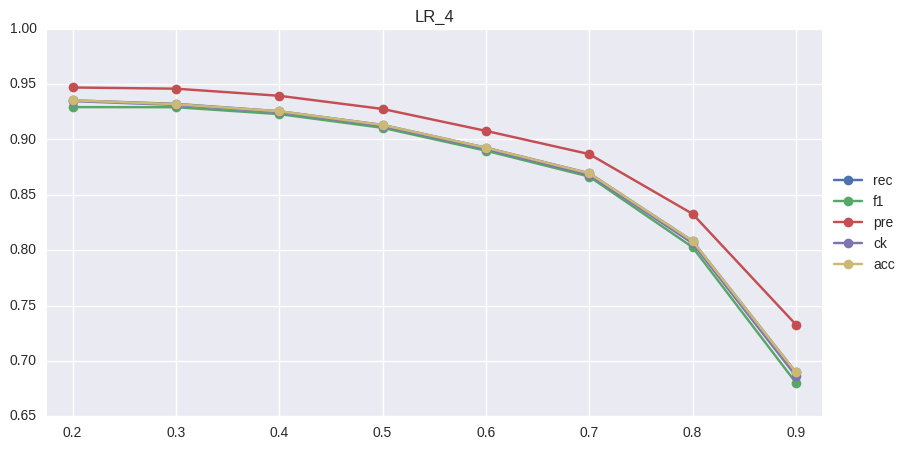

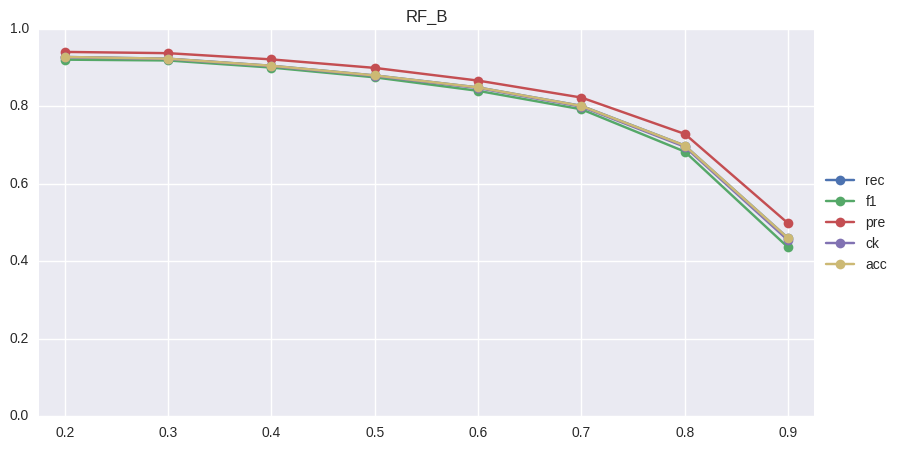

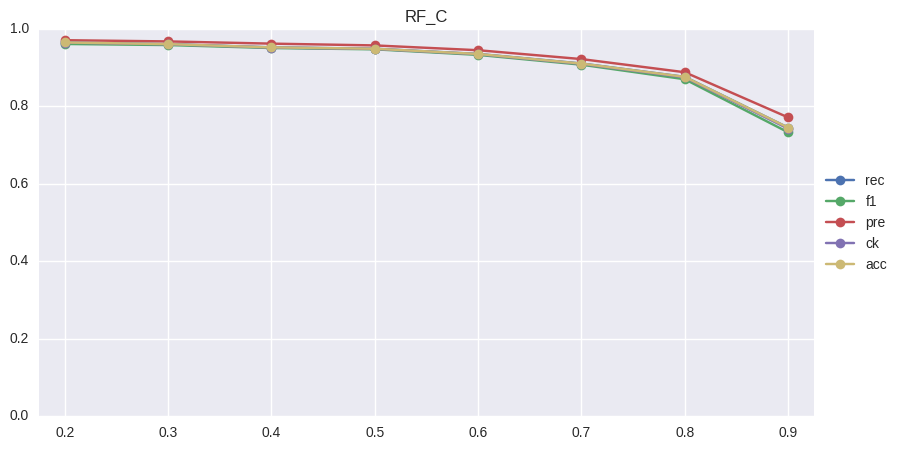

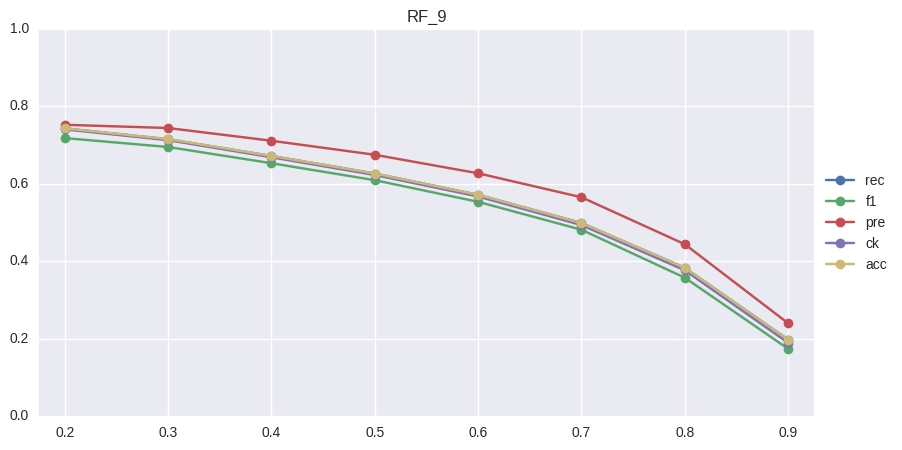

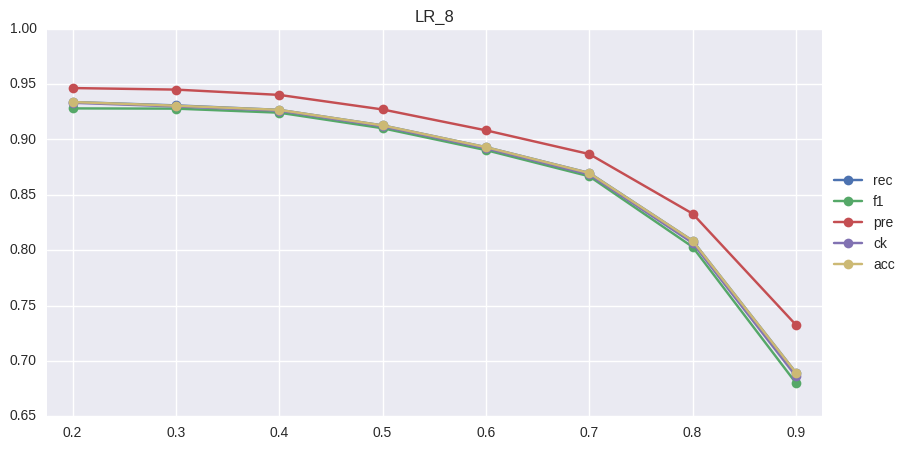

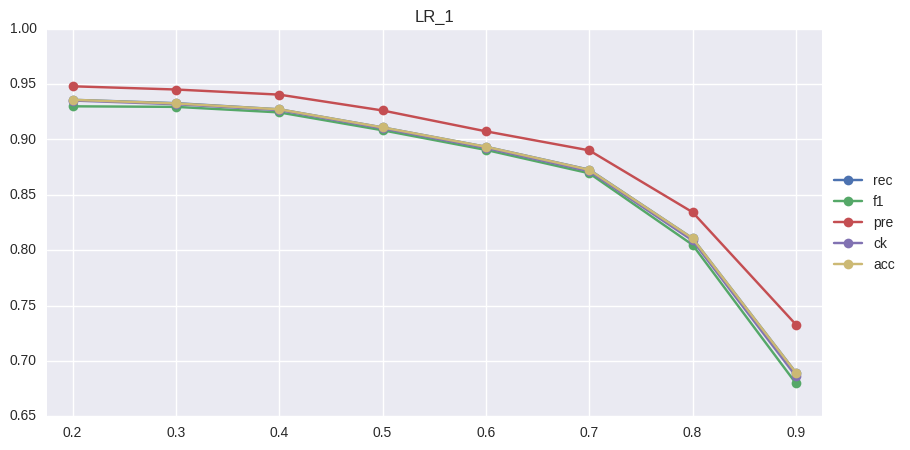

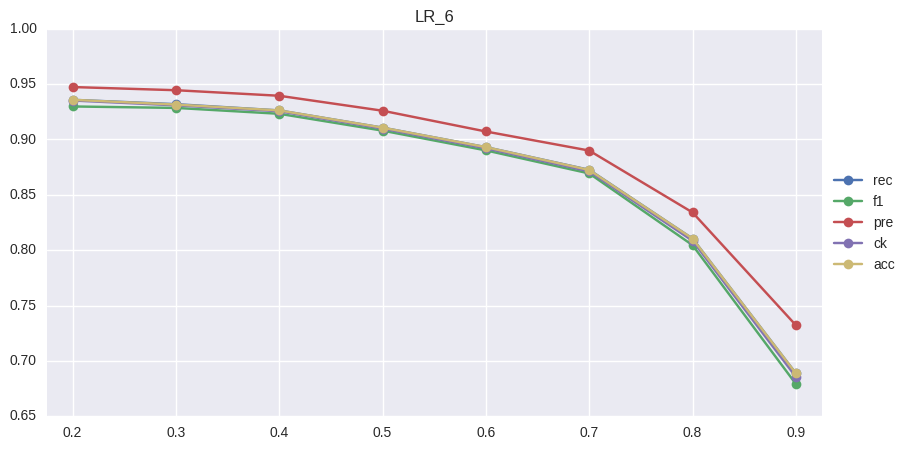

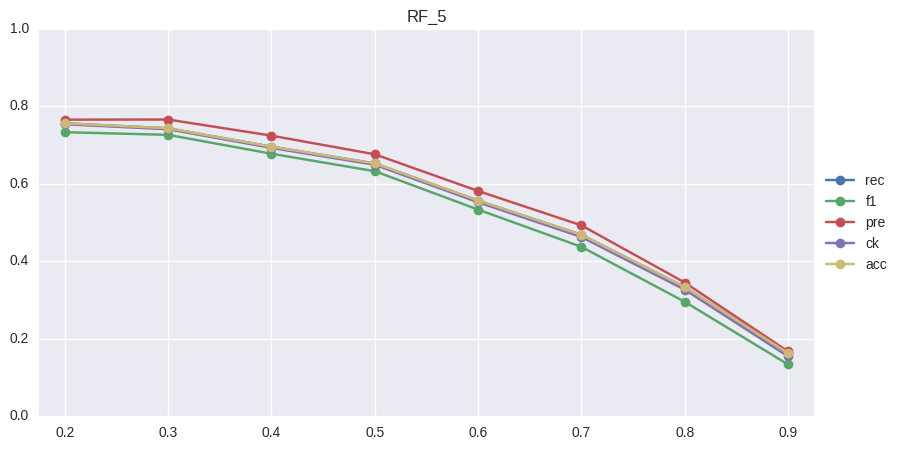

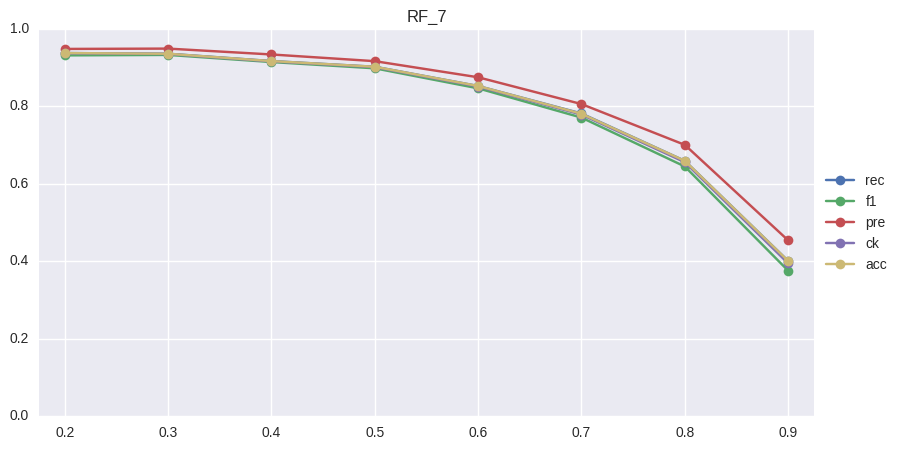

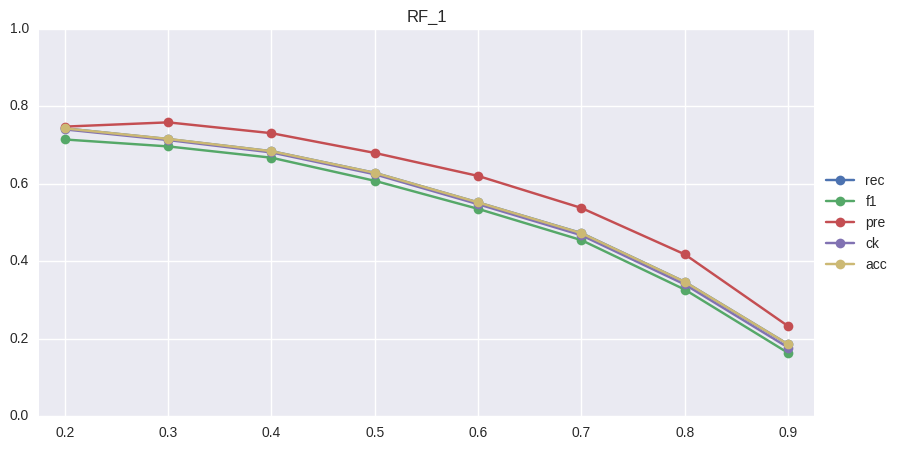

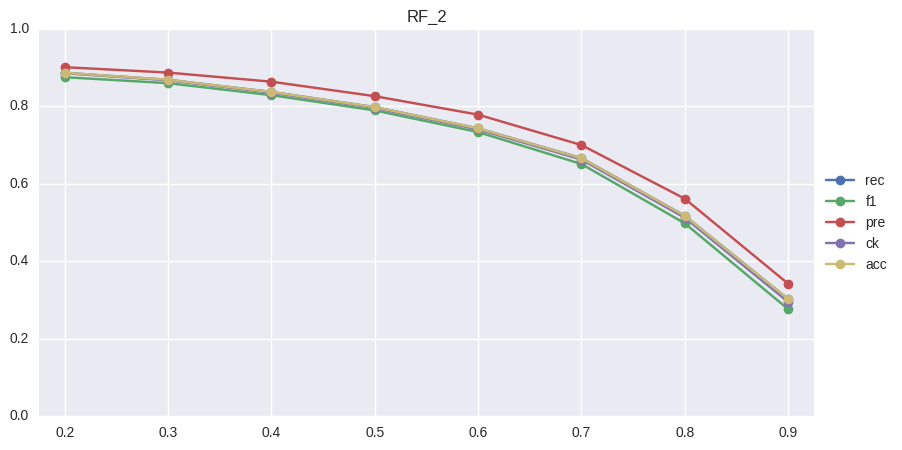

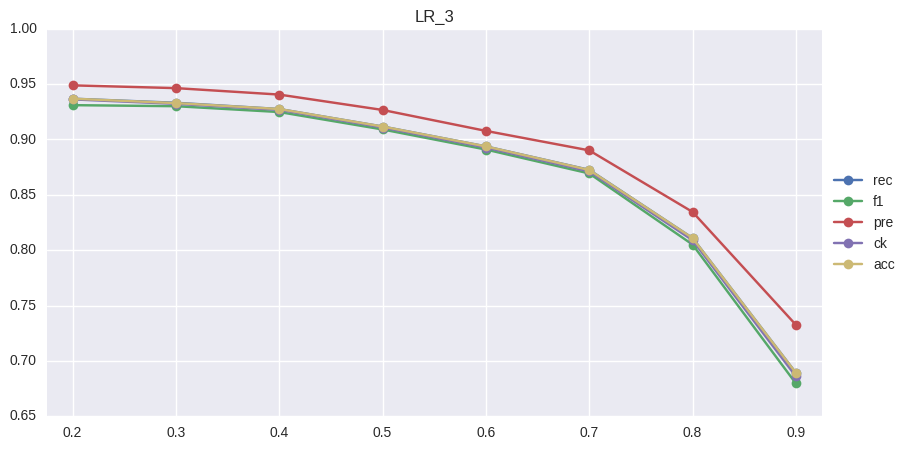

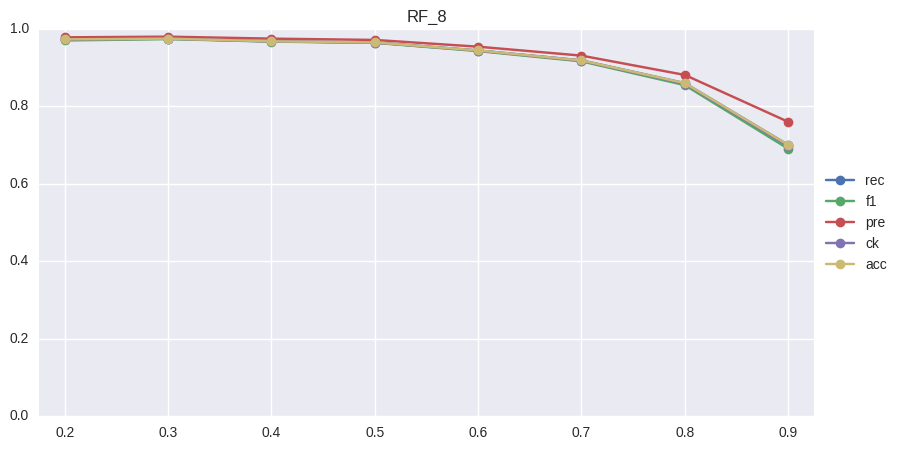

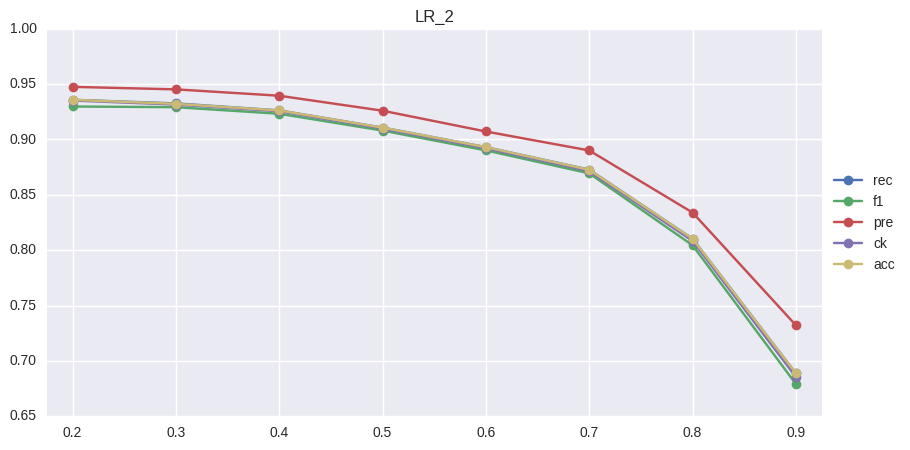

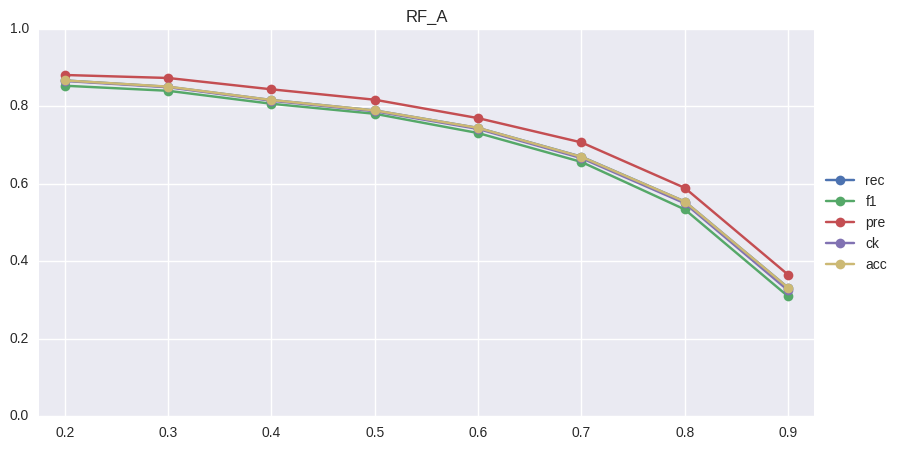

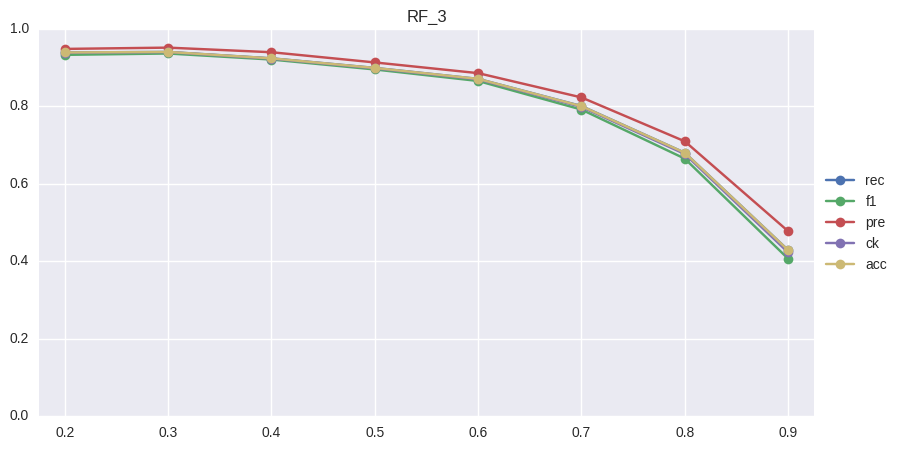

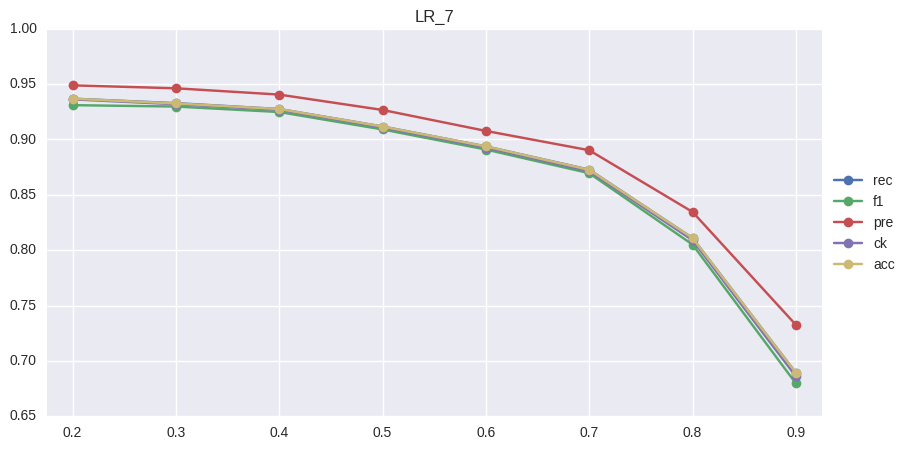

In [45]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns

for model in classifiers.keys():
    results = pd.DataFrame(columns=measures)
    
    for i in range(0,len(cl)):
        res = [np.mean(cl[i][model][measure]) for measure in measures.keys()]
        results.loc[sizes[i]] = res

    figsize(10, 5)
    ax = plt.subplot(111)

    ind = np.arange(results.shape[0])
    width = 0.2
    l = ax.plot(ind, results, "-o")
    plt.legend(iter(l), results.columns.tolist(), loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlim([-0.25, ind[-1]+.25])
    ax.set_xticks(ind)
    ax.set_xticklabels(results.index)
    
    if (model.startswith("LR")):
        ax.set_ylim([0.65,1])
    else:
        ax.set_ylim([0,1])
    plt.title(model)
    
    plt.savefig("plots/" + model + ".png")
    plt.show()

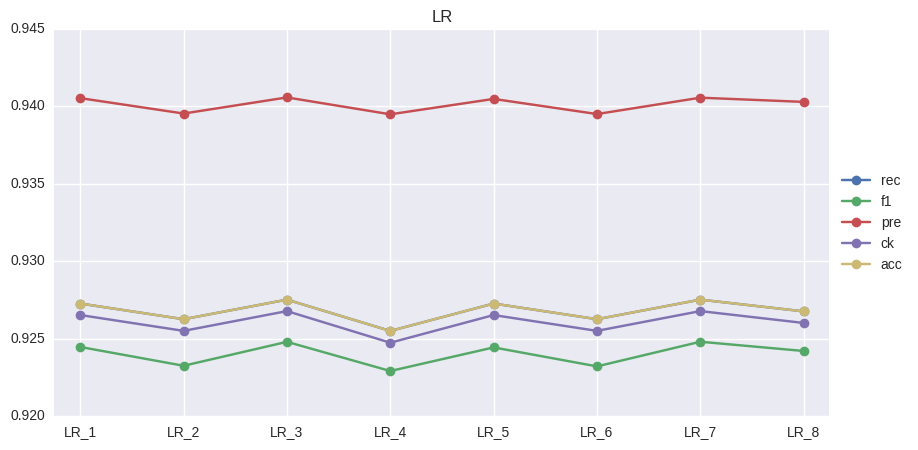

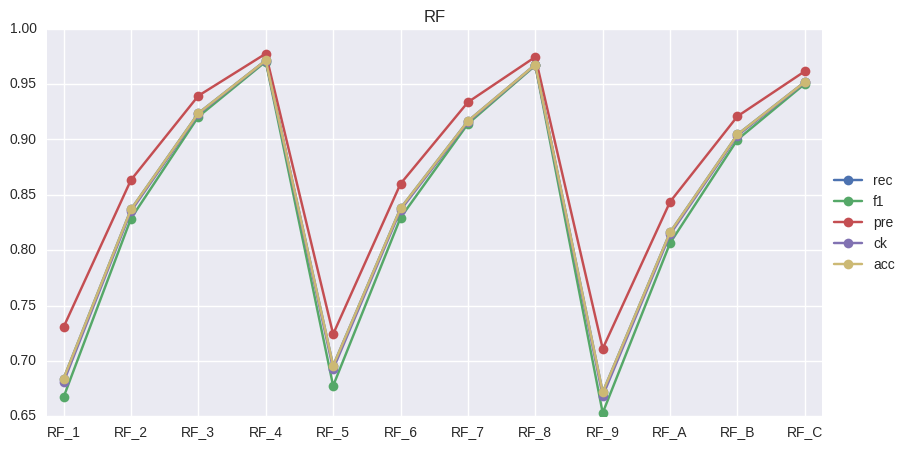

In [57]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns

def plot_param(classifier):
    results = pd.DataFrame(columns=measures)

    for model in classifiers.keys():
        if (model.startswith(classifier)):
            res = [np.mean(cl[2][model][measure]) for measure in measures.keys()]
            results.loc[model] = res

    results = results.sort_index()
    
    figsize(10, 5)
    ax = plt.subplot(111)

    ind = np.arange(results.shape[0])
    width = 0.2
    l = ax.plot(ind, results, "-o")
    plt.legend(iter(l), results.columns.tolist(), loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlim([-0.25, ind[-1]+.25])
    ax.set_xticks(ind)
    ax.set_xticklabels(results.index)
    plt.title(classifier)

    plt.savefig("plots/" + classifier + "_compare_param.png")
    plt.show()
    
plot_param("LR")
plot_param("RF")